In [52]:
from embeddings_utils import *
import pandas as pd
import numpy as np
import networkx as nx

import itertools
from node2vec import Node2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
nodes_all =  pd.read_csv('data/nodes_filtered.csv')
edges_all =  pd.read_csv('data/edges_filtered.csv')

In [54]:
# nodes_all.head()

In [55]:
# edges_all.head()

In [56]:
node_types = nodes_all['type'].unique()
nodes_all['type'].value_counts()

type
Protein            122740
GO                  40803
Disease             26899
Gene                21638
Phenotype           19645
Person               7801
Genomic feature      2393
Article              1134
Name: count, dtype: int64

In [57]:
edges_types = edges_all['predicate'].unique()
edges_all['predicate'].value_counts()

predicate
Molecularly interacts with               618856
Phenotype of                             516808
Has phenotype                            516808
Subclassof                               351598
Has participant                          125286
                                          ...  
Results in structural organization of         1
Is ubiquitination                             1
Is kinase activity                            1
Guided by                                     1
Preceded by                                   1
Name: count, Length: 117, dtype: int64

In [58]:
print(edges_types)

['Phenotype of' 'Molecularly interacts with' 'Subclassof' 'Function of'
 'Located in' 'Disease caused by disruption of' 'Has phenotype'
 'Has gene template' 'Participates in' 'Has function' 'Has gene product'
 'Has participant' 'Location of' 'Genetically interacts with'
 'Causes or contributes to condition' 'Has target end location'
 'Gene product of' 'Negatively regulates' 'Has modifier' 'Part of'
 'Has component' 'Regulates' 'Disease has feature' 'Has quality'
 'Disease causes disruption of' 'Positively regulates' 'Characteristic of'
 'Has material basis in germline mutation in'
 'Directly negatively regulates' 'Disease arises from feature' 'Output of'
 'Has part' 'Results in transport across' 'Occurs in' 'Has primary input'
 'Capable of part of' 'Has characteristic' 'Disease has major feature'
 'Results in disassembly of' 'Disease shares features of' 'Derives from'
 'Has target start location' 'Has origin' 'Results in assembly of'
 'Predisposes towards' 'Has constituent monomer' 'Ha

In [59]:
hpo_nodes = nodes_all[(nodes_all['type'] == 'Disease') | (nodes_all['type'] == 'Phenotype')]

# hpo_nodes.head()

In [60]:
phen = hpo_nodes[hpo_nodes['type'] == 'Phenotype']
phen

,name,type
11,<http://purl.obolibrary.org/obo/HP_0025537>,Phenotype
40,<http://purl.obolibrary.org/obo/HP_0000207>,Phenotype
56,<http://purl.obolibrary.org/obo/HP_0500147>,Phenotype
65,<http://purl.obolibrary.org/obo/HP_0002060>,Phenotype
91,<http://purl.obolibrary.org/obo/HP_0003073>,Phenotype
...,...,...
234092,<http://purl.obolibrary.org/obo/HP_0040245>,Phenotype
234100,<http://purl.obolibrary.org/obo/HP_0033814>,Phenotype
234101,<http://purl.obolibrary.org/obo/HP_6000518>,Phenotype
234102,<http://purl.obolibrary.org/obo/HP_0010366>,Phenotype


In [62]:
hpo_node_types = hpo_nodes['type'].unique()
hpo_nodes['type'].value_counts()

type
Disease      26899
Phenotype    19645
Name: count, dtype: int64

In [63]:
edges_with_type = add_node_types(edges_all, nodes_all)
edges_with_type.head()

,subject,predicate,object,x_type,y_type
0,<http://purl.obolibrary.org/obo/HP_0003392>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0011091>,Phenotype,Disease
1,<http://purl.obolibrary.org/obo/HP_0001328>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0003803>,Phenotype,Disease
2,<http://purl.obolibrary.org/obo/PR_P0CG47>,Molecularly interacts with,<http://purl.obolibrary.org/obo/PR_O43684>,Protein,Protein
3,<http://purl.obolibrary.org/obo/MONDO_0021154>,Subclassof,<http://purl.obolibrary.org/obo/MONDO_0005093>,Disease,Disease
4,<http://purl.obolibrary.org/obo/GO_0042803>,Function of,<http://purl.obolibrary.org/obo/PR_Q96CF2>,GO,Protein


In [ ]:
# Define the desired (x_type, y_type) pairs
desired_pairs = [
    ("Phenotype", "Disease"),
    ("Phenotype", "Phenotype"),
    ("Disease", "Phenotype"),
    ("Disease", "Disease")
]

# Filter the DataFrame
hpo_edges = edges_with_type[edges_with_type[["x_type", "y_type"]].apply(tuple, axis=1).isin(desired_pairs)]

# hpo_edges.head()

In [65]:
hpo_edges.groupby(['x_type', 'y_type']).size()

x_type     y_type   
Disease    Disease       46722
           Phenotype    454916
Phenotype  Disease      453260
           Phenotype     38806
dtype: int64

In [66]:
# Group by predicate and get value counts
predicate_counts = hpo_edges.groupby("predicate").size().reset_index(name="count")

# Get unique x_type and y_type for each predicate
predicate_details = hpo_edges.groupby("predicate").agg(
    x_types=("x_type", lambda x: ", ".join(x.unique())),
    y_types=("y_type", lambda y: ", ".join(y.unique())),
).reset_index()

# Merge counts with details
result = pd.merge(predicate_counts, predicate_details, on="predicate")
result.sort_values(by=['count'], ascending= False)


,predicate,count,x_types,y_types
10,Has phenotype,453260,Disease,Phenotype
15,Phenotype of,453260,Phenotype,Disease
18,Subclassof,71104,"Disease, Phenotype","Disease, Phenotype"
8,Has modifier,6425,"Phenotype, Disease",Phenotype
11,Has quality,5989,Phenotype,Phenotype
6,Has characteristic,1308,Disease,"Disease, Phenotype"
3,Disease has feature,1080,Disease,"Phenotype, Disease"
9,Has part,394,Phenotype,Phenotype
16,Predisposes towards,375,Disease,"Disease, Phenotype"
2,Disease arises from feature,154,Disease,"Phenotype, Disease"


In [ ]:
hpo_edges[hpo_edges['predicate'] == 'Subclassof']

In [68]:
desired_edges = ['Phenotype of', 'Subclassof']
hpo_edges_filtered = hpo_edges[hpo_edges['predicate'].isin(desired_edges)]
hpo_edges_filtered.head(5)

,subject,predicate,object,x_type,y_type
0,<http://purl.obolibrary.org/obo/HP_0003392>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0011091>,Phenotype,Disease
1,<http://purl.obolibrary.org/obo/HP_0001328>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0003803>,Phenotype,Disease
3,<http://purl.obolibrary.org/obo/MONDO_0021154>,Subclassof,<http://purl.obolibrary.org/obo/MONDO_0005093>,Disease,Disease
7,<http://purl.obolibrary.org/obo/HP_0000602>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0011945>,Phenotype,Disease
12,<http://purl.obolibrary.org/obo/HP_0010841>,Phenotype of,<http://purl.obolibrary.org/obo/MONDO_0024556>,Phenotype,Disease


In [69]:
hpo_edges_filtered.value_counts(hpo_edges_filtered['predicate'])

predicate
Phenotype of    453260
Subclassof       71104
Name: count, dtype: int64

In [70]:
G = nx.DiGraph()

# Add nodes with attributes
for idx, row in hpo_nodes.iterrows():
    G.add_node(row['name'], node_type=row['type'])

# Add edges with attributes
for idx, row in hpo_edges_filtered.iterrows():
    G.add_edge(row['subject'], row['object'], relation=row['predicate'])


In [71]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 46544
Number of edges: 524364


In [72]:
if nx.is_directed_acyclic_graph(G):
    print("The graph is acyclic.")
else:
    print("The graph has cycles.")


The graph has cycles.


In [73]:
# Filter nodes of type 'Phenotype'
phenotype_nodes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == 'Phenotype']

# Create a subgraph with only 'Phenotype' nodes
phenotype_subgraph = G.subgraph(phenotype_nodes)

# Find cycles in the subgraph
phenotype_cycles = list(nx.simple_cycles(phenotype_subgraph))

# Check if there are cycles and count them
if phenotype_cycles:
    print(f"There are {len(phenotype_cycles)} cycle(s) involving nodes of type 'Phenotype'.")
    print("Cycles:", phenotype_cycles)
else:
    print("No cycles involving nodes of type 'Phenotype'.")


No cycles involving nodes of type 'Phenotype'.


In [ ]:
roots = []
for node in phenotype_subgraph.nodes():
    node_attrs = phenotype_subgraph.nodes[node]
    if node_attrs.get('parents', []) == []:
        roots.append(node)

# print("Root nodes:", roots)
print(len(roots))


In [75]:
isoleted_phen_nodes = ['<http://purl.obolibrary.org/obo/PATO_0002506>', 
                  '<http://purl.obolibrary.org/obo/PATO_0001871>', 
                  '<http://purl.obolibrary.org/obo/PATO_0001979>']

for node in isoleted_phen_nodes:
    G.remove_node(node)
    phenotype_nodes.remove(node)
    # phenotype_subgraph.remove_node(node)

In [76]:
phen_roots = ['<http://purl.obolibrary.org/obo/HP_0000001>', '<http://purl.obolibrary.org/obo/PATO_0000001>']

levels = {}
for node in phenotype_subgraph.nodes():
    for root in phen_roots:
        if nx.has_path(phenotype_subgraph, node, root):
            level = nx.shortest_path_length(phenotype_subgraph, node, root)
            levels[node] = level

In [77]:
no = []
for node in phenotype_subgraph.nodes():
    if node not in levels.keys():
        no.append(node)

len(no)
no 

[]

In [78]:
# Filter nodes of type 'Phenotype'
disease_nodes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == 'Disease']

# Create a subgraph with only 'Phenotype' nodes
disease_subgraph = G.subgraph(disease_nodes)

# Find cycles in the subgraph
disease_cycles = list(nx.simple_cycles(disease_subgraph))

# Check if there are cycles and count them
if disease_cycles:
    print(f"There are {len(disease_cycles)} cycle(s) involving nodes of type 'Disease'.")
    print("Cycles:", disease_cycles)
else:
    print("No cycles involving nodes of type 'Disease'.")

There are 11 cycle(s) involving nodes of type 'Disease'.
Cycles: [['<http://purl.obolibrary.org/obo/MONDO_0016698>', '<http://purl.obolibrary.org/obo/MONDO_0016697>'], ['<http://purl.obolibrary.org/obo/MONDO_0006960>', '<http://purl.obolibrary.org/obo/MONDO_0001543>'], ['<http://purl.obolibrary.org/obo/MONDO_0005083>', '<http://purl.obolibrary.org/obo/MONDO_0006601>'], ['<http://purl.obolibrary.org/obo/MONDO_0008434>', '<http://purl.obolibrary.org/obo/MONDO_0022754>'], ['<http://purl.obolibrary.org/obo/MONDO_0006662>', '<http://purl.obolibrary.org/obo/MONDO_0007015>'], ['<http://purl.obolibrary.org/obo/MONDO_0002812>', '<http://purl.obolibrary.org/obo/MONDO_0002008>'], ['<http://purl.obolibrary.org/obo/MONDO_0019635>', '<http://purl.obolibrary.org/obo/MONDO_0008698>'], ['<http://purl.obolibrary.org/obo/MONDO_0007743>', '<http://purl.obolibrary.org/obo/MONDO_0005302>'], ['<http://purl.obolibrary.org/obo/MONDO_0019245>', '<http://purl.obolibrary.org/obo/MONDO_0019255>'], ['<http://purl.o

In [135]:
successors_node= list(G.successors('<http://purl.obolibrary.org/obo/MONDO_0016697>'))
predecessors_node = list(G.predecessors('<http://purl.obolibrary.org/obo/MONDO_0016697>'))
print(successors_node)
print(predecessors_node)
print(G.get_edge_data('<http://purl.obolibrary.org/obo/MONDO_0016698>', '<http://purl.obolibrary.org/obo/MONDO_0016697>'))
print(G.get_edge_data('<http://purl.obolibrary.org/obo/MONDO_0016697>','<http://purl.obolibrary.org/obo/MONDO_0016698>'))

['<http://purl.obolibrary.org/obo/MONDO_0016698>']
['<http://purl.obolibrary.org/obo/MONDO_0007667>', '<http://purl.obolibrary.org/obo/MONDO_0016698>']
{'relation': 'Subclassof', 'weight': 1}
{'relation': 'Subclassof', 'weight': 1}


In [136]:
for edge in disease_cycles:
    u, v = edge
    G.remove_edge(u, v)

In [137]:
print(G.get_edge_data('<http://purl.obolibrary.org/obo/MONDO_0016698>', '<http://purl.obolibrary.org/obo/MONDO_0016697>'))
print(G.get_edge_data('<http://purl.obolibrary.org/obo/MONDO_0016697>','<http://purl.obolibrary.org/obo/MONDO_0016698>'))

None
{'relation': 'Subclassof', 'weight': 1}


In [80]:
G = annotated_disease_indirect(G)

In [81]:
# Get all nodes with 'annotated_disease' attribute and check for zeros
zeros = 0

for node, data in G.nodes(data=True):
    if G.nodes[node].get("node_type") == "Phenotype":
        if data['annotated_disease'] == []:
            zeros += 1

print(zeros)


1158


In [82]:
G = get_children(G, node_type='Phenotype')

In [83]:
zeros = 0

for node, data in G.nodes(data=True):
    if G.nodes[node].get("node_type") == "Phenotype":
        if data['children'] == [] and data['annotated_disease'] == []:
            zeros += 1

print(zeros)

823


In [84]:
G = get_parents(G, node_type="Phenotype")

In [85]:
zeros = 0

for node, data in G.nodes(data=True):
    if G.nodes[node].get("node_type") == "Phenotype":
        if data['parents'] == []:
            zeros += 1

print(zeros)

2


In [ ]:
# Print the first 10 nodes and their attributes
# for node, attrs in itertools.islice(G.nodes(data=True), 10):
    # print(f"Node {node}: {attrs}")

In [139]:

def annotated_disease_indirect(G, node_type):
    """
    Annotates each node in a NetworkX graph with a list of associated disease nodes,
    considering both direct and indirect relationships.

    Parameters:
        G (nx.DiGraph): A NetworkX graph with nodes having a 'node_type' attribute.

    Returns:
        G (nx.DiGraph): The graph with an 'annotated_disease' attribute added to each node.
    """
    for node in G.nodes():
        if G.nodes[node].get("node_type") != node_type:
            continue
        
        # Use BFS to find all reachable disease nodes from the current node
        visited = set()
        queue = [node]
        associated_diseases = set()
        
        while queue:
            current = queue.pop(0)
            
            # Avoid cycles by skipping visited nodes
            if current in visited:
                continue
            
            visited.add(current)
            
            for successor in G.successors(current):
                if G.nodes[successor].get("node_type") == "Disease":
                    associated_diseases.add(successor)
                elif successor not in visited:
                    queue.append(successor)
        
        # Annotate the current node with its associated diseases
        G.nodes[node]["annotated_disease"] = list(associated_diseases)
        
    return G


In [142]:
from collections import deque

def calculate_nt(G, node_type):
    phenotypes = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') == node_type]

    annotated_disease_indirect(G, node_type)
    get_children(G, node_type)
    get_parents(G, node_type)

    queue = deque(node for node in phenotypes if len(G.nodes[node]["children"]) == 0)
    visited = set()

    while queue:
        node = queue.pop()
        visited.add(node)

        for parent in G.nodes[node]["parents"]:
            for disease in G.nodes[node]["annotated_disease"]:
                if disease not in G.nodes[parent]["annotated_disease"]:
                    G.nodes[parent]["annotated_disease"].append(disease)

            if all(child in visited for child in G.nodes[parent]["children"]):
                if parent not in visited:
                    queue.appendleft(parent)

    nt_values = {
        node: len(G.nodes[node]["annotated_disease"]) for node in phenotypes
    }

    return nt_values


In [101]:
nt_values = calculate_nt(G, node_type='Phenotype')

In [102]:
zeros = 0

for key, value in nt_values.items():
        if value == 0:
            zeros += 1

print(zeros)

1138


In [ ]:
nt_values

In [104]:
nt_values['<http://purl.obolibrary.org/obo/HP_0000001>']


11908

In [143]:
nt_values_disease = calculate_nt(G, node_type= 'Disease')

In [ ]:
nt_values_disease

In [105]:
# Convert dictionary values to a list
nt_values_list = list(nt_values.values())

print("len:", len(nt_values_list))
print("Min:", min(nt_values_list))
print("Q1:", np.quantile(nt_values_list, 0.25))
print("Median:", np.median(nt_values_list))
print("Q3:", np.quantile(nt_values_list, 0.75))
print("Mean:", np.mean(nt_values_list))
print("Max:", max(nt_values_list))

len: 19642
Min: 0
Q1: 476.0
Median: 777.0
Q3: 1125.75
Mean: 938.1575705121678
Max: 11908


In [145]:
# Convert dictionary values to a list
nt_values_list = list(nt_values_disease.values())

print("len:", len(nt_values_list))
print("Min:", min(nt_values_list))
print("Q1:", np.quantile(nt_values_list, 0.25))
print("Median:", np.median(nt_values_list))
print("Q3:", np.quantile(nt_values_list, 0.75))
print("Mean:", np.mean(nt_values_list))
print("Max:", max(nt_values_list))

len: 26899
Min: 0
Q1: 1.0
Median: 2.0
Q3: 4.0
Mean: 9.169188445667125
Max: 7091


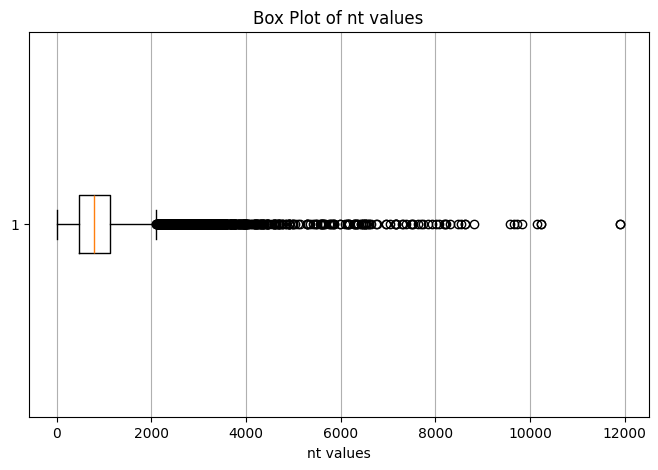

In [106]:
import matplotlib.pyplot as plt

# Create a box plot for the degrees
plt.figure(figsize=(8, 5))
plt.boxplot(nt_values_list, vert=False)
plt.title("Box Plot of nt values")
plt.xlabel("nt values")
plt.grid(True, axis='x')

plt.show()

In [107]:
IC_values_phen = calculate_ic_values(G, nt_values)

In [108]:
# Convert dictionary values to a list
ic_values_list = list(IC_values_phen.values())

print("Min:", min(ic_values_list))
print("Median:", np.median(ic_values_list))
print("Mean:", np.mean(ic_values_list))
print("Max:", max(ic_values_list))

Min: 0.0
Median: 3.4405891195140508
Mean: 3.327244294297962
Max: 10.199844390177743


In [ ]:
IC_values_phen['<http://purl.obolibrary.org/obo/HP_0000001>']

0.8148786680420769

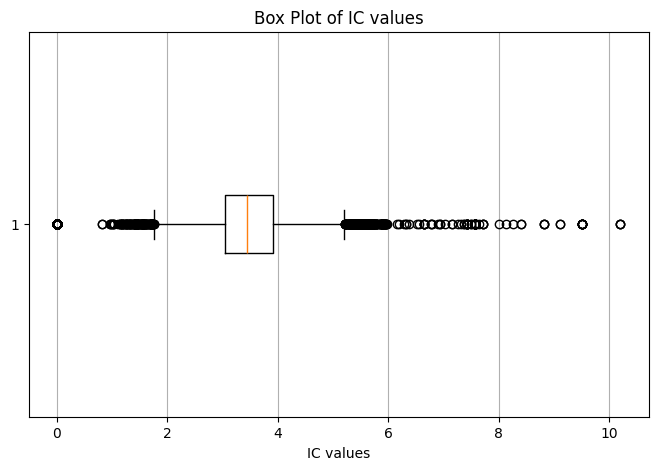

In [110]:
# Create a box plot for the degrees
plt.figure(figsize=(8, 5))
plt.boxplot(ic_values_list, vert=False)
plt.title("Box Plot of IC values")
plt.xlabel("IC values")
plt.grid(True, axis='x')

plt.show()

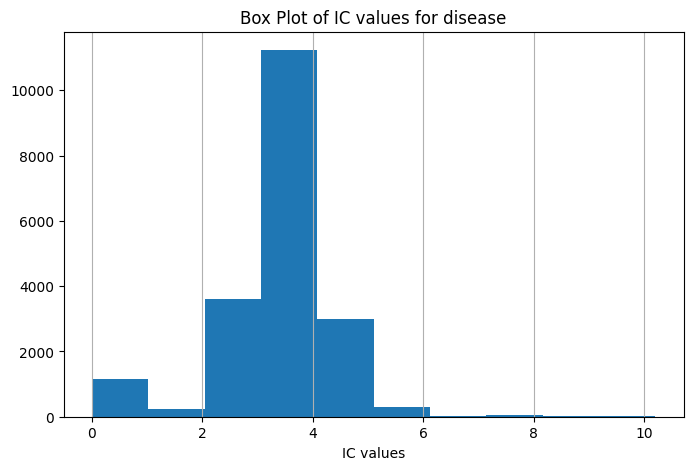

In [171]:
plt.figure(figsize=(8, 5))
plt.hist(ic_values_list)
plt.title("Box Plot of IC values for disease")
plt.xlabel("IC values")
plt.grid(True, axis='x')

In [186]:
# plt.figure(12, 8)
axises = []
for key,value in IC_values_phen.items():
        if key in levels:
            axises.append([value, levels[key]])
axises[0:2]

[[3.6602584345600744, 6], [3.763694021808316, 7]]

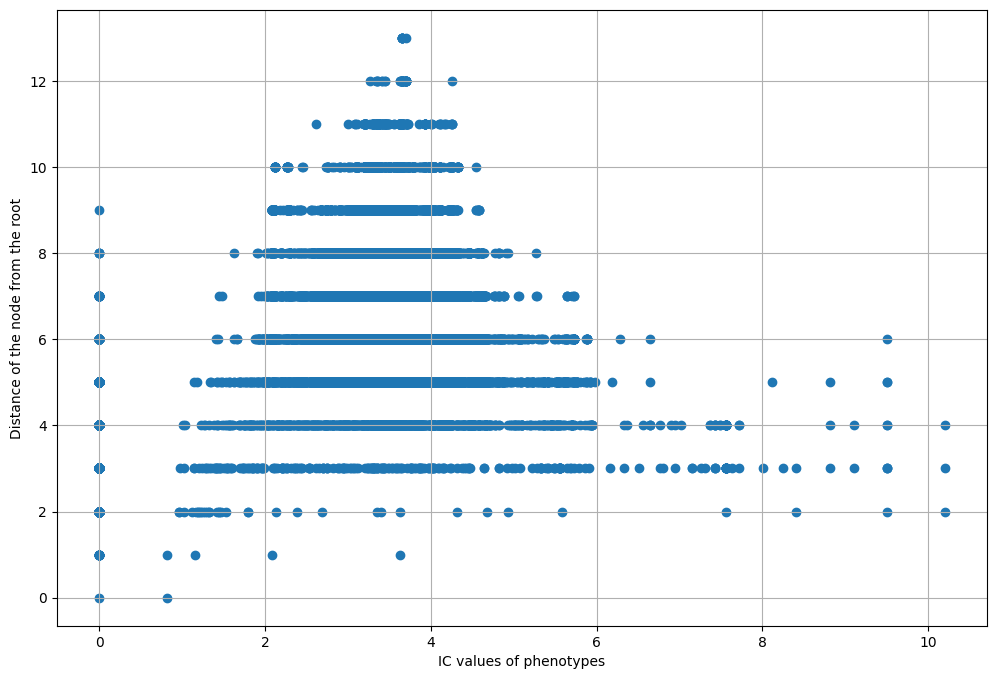

In [197]:
import matplotlib.pyplot as plt

# Separate x and y values from `axises`
x_values = [point[0] for point in axises]
y_values = [point[1] for point in axises]

# Create a figure with specified dimensions
plt.figure(figsize=(12, 8))  # Use figsize=(width, height) in inches

# Plot scatter plot
plt.scatter(x_values, y_values)

plt.xlabel('IC values of phenotypes')
plt.ylabel("Distance of the node from the root")
plt.grid()
# Show the plot
plt.show()


In [146]:
ic_values_disease = calculate_ic_values(G, nt_values_disease)

In [ ]:
ic_values_disease

In [148]:
# Convert dictionary values to a list
ic_values_disease_list = list(ic_values_disease.values())

print("Min:", min(ic_values_disease_list))
print("Median:", np.median(ic_values_disease_list))
print("Mean:", np.mean(ic_values_disease_list))
print("Max:", max(ic_values_disease_list))

Min: 0.0
Median: 9.506697209617798
Mean: 9.314925552340535
Max: 10.199844390177743


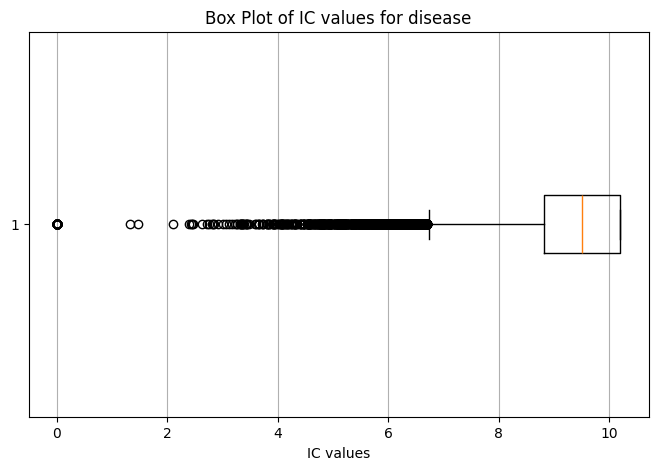

In [149]:
# Create a box plot for the degrees
plt.figure(figsize=(8, 5))
plt.boxplot(ic_values_disease_list, vert=False)
plt.title("Box Plot of IC values for disease")
plt.xlabel("IC values")
plt.grid(True, axis='x')

plt.show()

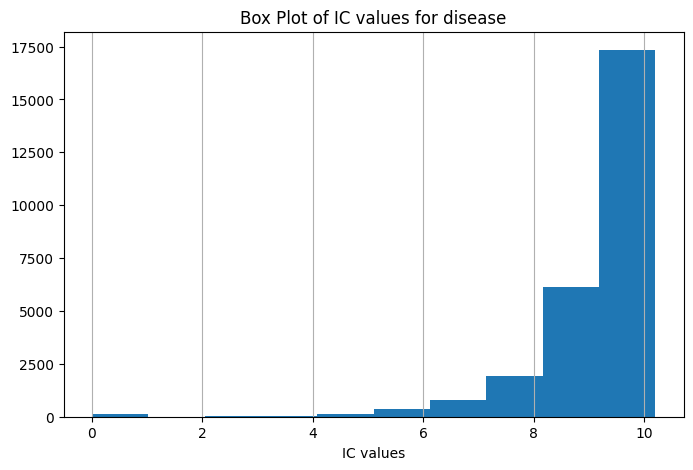

In [170]:
plt.figure(figsize=(8, 5))
plt.hist(ic_values_disease_list)
plt.title("Box Plot of IC values for disease")
plt.xlabel("IC values")
plt.grid(True, axis='x')

In [151]:
all_ics = ic_values_disease | IC_values_phen
len(all_ics)

46541

In [ ]:
weights = get_weights(all_ics, 1, 0.01)
weights

In [153]:
for edge in G.edges():
    node1, node2 = edge
    if node2 in weights.keys():
        G[node1][node2]['weight'] = weights[node2]
    else:
        G[node1][node2]['weight'] = 1
        

In [156]:
G.get_edge_data('<http://purl.obolibrary.org/obo/MONDO_0021154>', '<http://purl.obolibrary.org/obo/MONDO_0005093>')

{'relation': 'Subclassof', 'weight': 3.3778908246118884}

In [117]:
node2vec = Node2Vec(G,
                    dimensions= 256,
                    walk_length= 5,
                    num_walks= 100,
                    weight_key= 'weight',
                    p = 1,
                    q= 1,
                    workers= 4

)

Computing transition probabilities: 100%|██████████| 46541/46541 [00:10<00:00, 4569.70it/s]


In [157]:
# Fit the Node2Vec model
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Retrieve embeddings for each node as a dictionary
node_embeddings = {node: model.wv[node] for node in G.nodes()}


In [ ]:
# type(node_embeddings)
node_embeddings

In [159]:
def tsne_embeddings(node_embeddings):
    # Assuming embedding_values is a list of embedding vectors
    embedding_values_list = list(node_embeddings.values())
    embedding_values = np.array(embedding_values_list) 
    # Reduce to 2D
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embedding_values)
    return embeddings_2d

In [160]:
embeddings_2d = tsne_embeddings(node_embeddings)

In [161]:
graph_node_types = {node: G.nodes[node]['node_type'] for node in G.nodes()}

Unique Node Types: ['Disease', 'Phenotype']
Type to Color Mapping: {'Disease': 0, 'Phenotype': 1}


C:\Users\User\AppData\Local\Temp\ipykernel_14420\3979161179.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('coolwarm', len(unique_types))  # Distinct colormap for two types


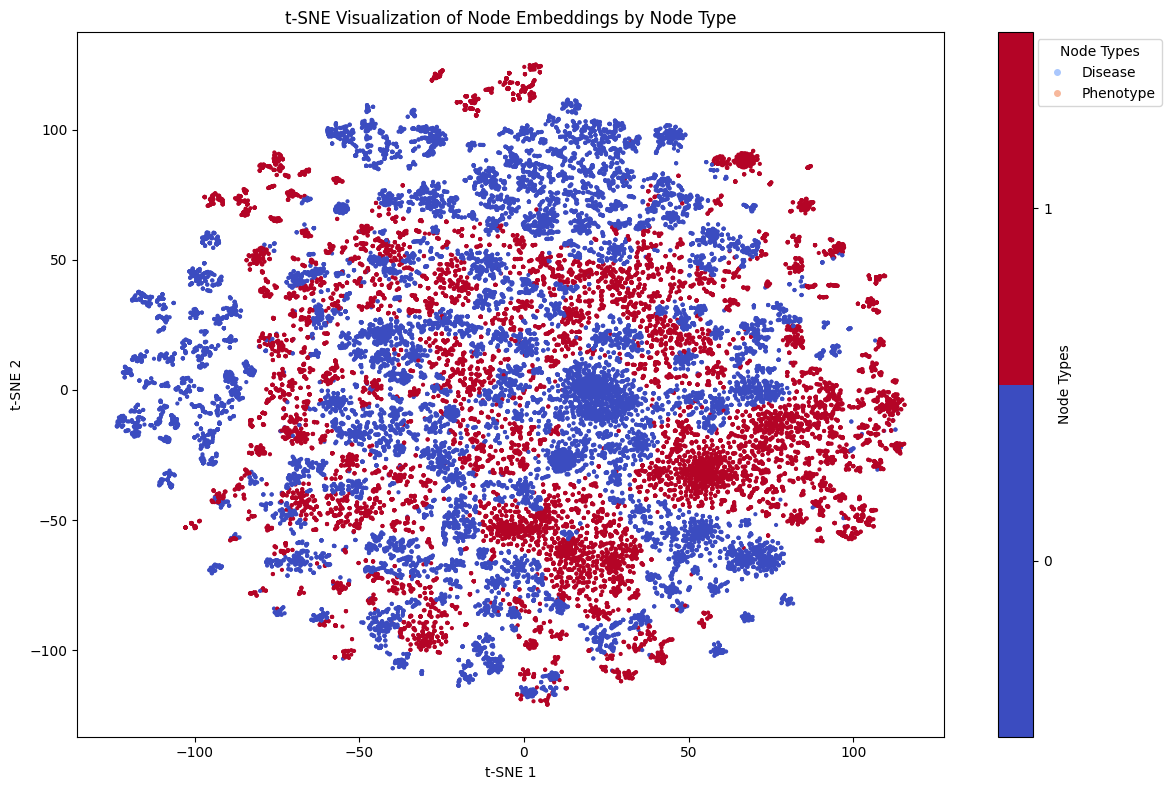

In [162]:
# Ensure graph_node_types has correct values
unique_types = sorted(set(graph_node_types.values()))  # ['Phenotype', 'Disease']
type_to_color = {node_type: idx for idx, node_type in enumerate(unique_types)}

# Debug: Check the mappings
print("Unique Node Types:", unique_types)
print("Type to Color Mapping:", type_to_color)

# Create a color array
node_colors = np.array([type_to_color[graph_node_types[node]] for node in G.nodes()])

# Plot the reduced embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    s=4,  # Point size
    c=node_colors,  # Color based on node type
    cmap=plt.cm.get_cmap('coolwarm', len(unique_types))  # Distinct colormap for two types
)
plt.colorbar(scatter, ticks=range(len(unique_types)), label="Node Types")
plt.clim(-0.5, len(unique_types) - 0.5)

# Add legend for node types
colormap = sns.color_palette("coolwarm", len(unique_types))
handles = [plt.Line2D([], [], marker="o", color=colormap[idx], linestyle='', markersize=4)
           for idx, node_type in enumerate(unique_types)]
plt.legend(handles, unique_types, title="Node Types", bbox_to_anchor=(1.1, 1), loc='upper left')

plt.title("t-SNE Visualization of Node Embeddings by Node Type")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [163]:
phenotype_embeddings = {}
for key, value in node_embeddings.items():
    if key in phenotype_nodes:
        phenotype_embeddings[key] = value

# phen_embedding_values_list = list(phenotype_embeddings.values())
# pehn_embedding_values = np.array(phen_embedding_values_list) 

# Reduce to 2D
# tsne = TSNE(n_components=2, random_state=42)
phen_embeddings_2d = tsne_embeddings(phenotype_embeddings)



Unique Node Types: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
Type to Color Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13}
node colors are: [ 6  7 10 ...  4  7  5]


C:\Users\User\AppData\Local\Temp\ipykernel_14420\4018126164.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab20', len(unique_levels))  # Distinct colormap for two types


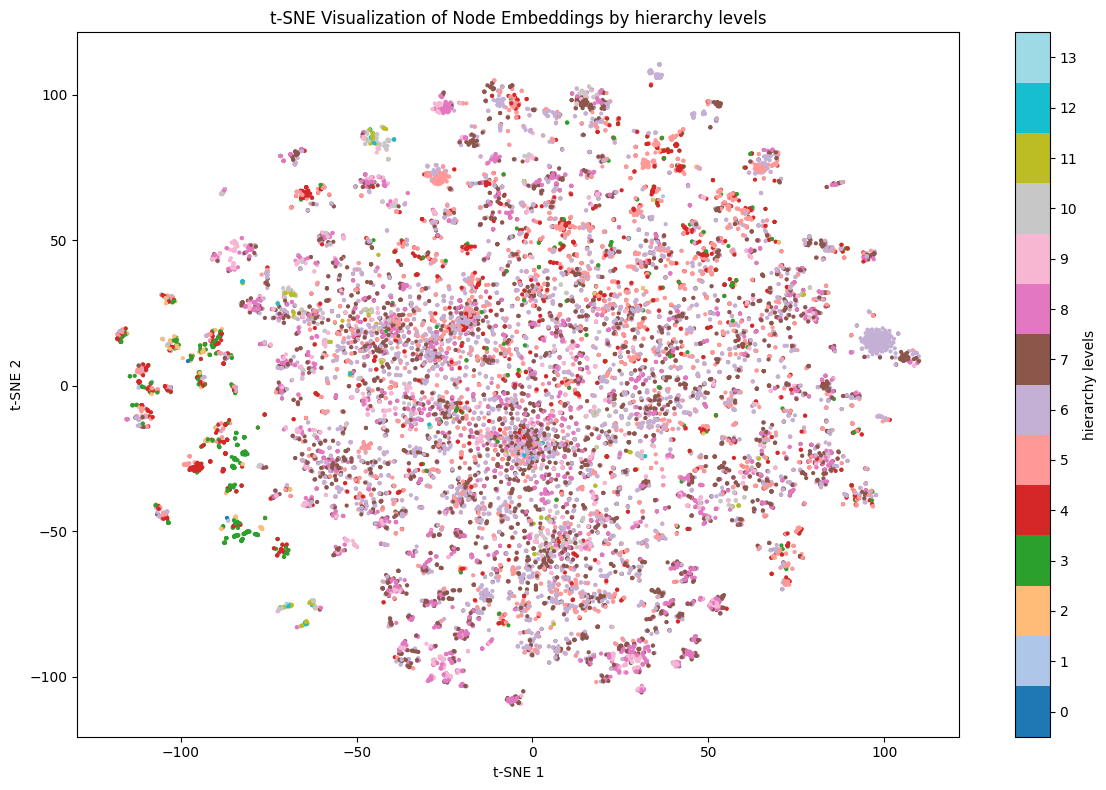

In [165]:
# Ensure graph_node_types has correct values
unique_levels = sorted(set(levels.values()))
levels_to_color = {node_type: idx for idx, node_type in enumerate(unique_levels)}

# Check the mappings
print("Unique Node Types:", unique_levels)
print("Type to Color Mapping:", levels_to_color)

# Create a color array
node_colors = np.array([levels_to_color[levels[node]] for node in phenotype_nodes])
print('node colors are:', node_colors)
# Plot the reduced embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    phen_embeddings_2d[:, 0],
    phen_embeddings_2d[:, 1],
    s=4,  # Point size
    c=node_colors,  # Color based on hierarchy levels
    cmap=plt.cm.get_cmap('tab20', len(unique_levels))  # Distinct colormap for two types
)
plt.colorbar(scatter, ticks=range(len(unique_levels)), label="hierarchy levels")
plt.clim(-0.5, len(unique_levels) - 0.5)

plt.title("t-SNE Visualization of Node Embeddings by hierarchy levels")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


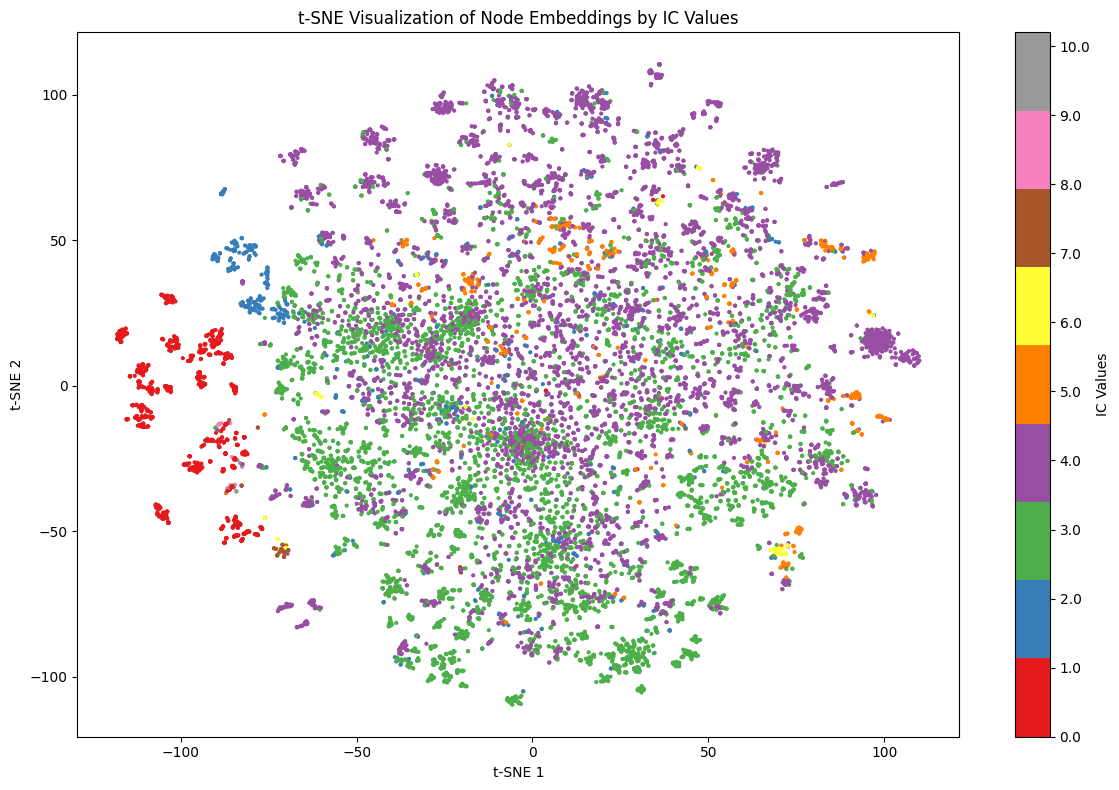

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the reduced embeddings
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    phen_embeddings_2d[:, 0],
    phen_embeddings_2d[:, 1],
    s=4,  # Point size
    c=ic_values_list,
    cmap=plt.cm.Set1,  # Continuous colormap
)

# Add a colorbar with the IC range
cbar = plt.colorbar(scatter, label="IC Values")
tick_positions = np.linspace(0, 10, 11)  # Positions in the normalized range
tick_labels = np.linspace(0, 10, 11)  # Corresponding IC values
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)

plt.title("t-SNE Visualization of Node Embeddings by IC Values")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


In [218]:
import json

# Convert ndarray to list for JSON serialization
serializable_embeddings = {
    key: value.tolist() if isinstance(value, np.ndarray) else value
    for key, value in node_embeddings.items()
}

# Save to JSON file
with open('phenotype_embeddings.json', 'w') as json_file:
    json.dump(serializable_embeddings, json_file, indent=4)